# Notes

This notebook is based on Paper_Plots_IF_vS_DM.ipynb

It plots some data requested by Laura (via mattermost) on 02/02/2023:

"Hello. I've been staring at Figure 9. 
I assume that you have the mass of each halo plotted in this figure. Can you quickly make a scatter plot of DM vs. b color coded by halo mass at a few fixed redshifts?"


# Imports

In [1]:
import os
import numpy as np
import illustris_python as il
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from astropy.cosmology import Planck15 as cosmosource
from astropy import constants as c
from astropy import units as u

# Load the data

In [2]:
#choose simulation to process
sim_to_process = 'TNG300-1'
#simulation data path
basePath = '/virgotng/universe/IllustrisTNG/{0}/output/'.format(sim_to_process)


snap_number = 59#21


header = il.groupcat.loadHeader(basePath,snap_number) #get header
redshift=header['Redshift'] #get redshift of snapshot

h = 0.6774 #(little h according to illustris)

In [3]:
##########################################################################
#load snapshot data (shIDs, DMs [physical] [pc/cc], IFs [physical] [kpc])#
##########################################################################

sh_IDs = np.load('/u/cwalker/Illustris_Zhang_Method/Impact_Factor_DM_Analysis_Output/Snap_{0}_IDs_sh.npy'.format(snap_number),allow_pickle=True)
sh_DMs = np.load('/u/cwalker/Illustris_Zhang_Method/Impact_Factor_DM_Analysis_Output/Snap_{0}_DMs_sh.npy'.format(snap_number),allow_pickle=True)
sh_IFs = np.load('/u/cwalker/Illustris_Zhang_Method/Impact_Factor_DM_Analysis_Output/Snap_{0}_IFs_sh.npy'.format(snap_number),allow_pickle=True)


In [4]:
print(len(sh_IDs))

9797


In [5]:
##################################
#load the masses for each subhalo#
##################################

try: #see if we've already created the mass list before
    shmasses=np.load('/u/cwalker/Illustris_Zhang_Method/Impact_Factor_DM_Analysis_Output/Snap_{0}_Mass_sh.npy'.format(snap_number),allow_pickle=True)
    print('masses loaded')
    
except: #if not, create it from scratch
    shmasses = [] #initialise array to hold masses

    for shID in sh_IDs:
        #load the subhalo data
        sh_data = il.groupcat.loadSingle(basePath, snap_number, subhaloID=shID)

        #get the total mass of all particles/cells bound to the subhalo (all types) [code units = msun/h]
        sh_centmass = sh_data['SubhaloMass']
        #print('Total mass of all types of matter in subhalo {0}: {1}'.format(shID,sh_centmass))
        shmasses.append(sh_centmass)
    print('done all {0} halos for snapshot {0}'.format(len(sh_IDs),snap_number))

done all 9797 halos for snapshot 9797


min halo mass: 0.11195696145296097, max halo mass: 54314.2109375 msun/h
bounds of our mass ranges: [         1         10        100       1000      10000     100000
    1000000   10000000  100000000 1000000000]
min bound: 1.00E+00, max bound 1.00E+01


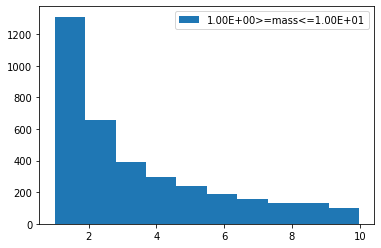

min bound: 1.00E+01, max bound 1.00E+02


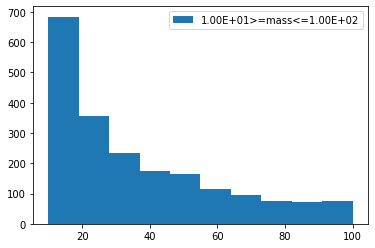

min bound: 1.00E+02, max bound 1.00E+03


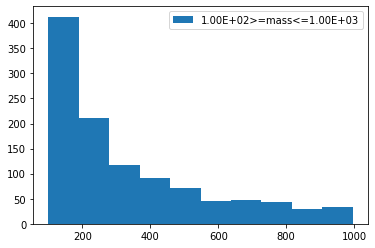

min bound: 1.00E+03, max bound 1.00E+04


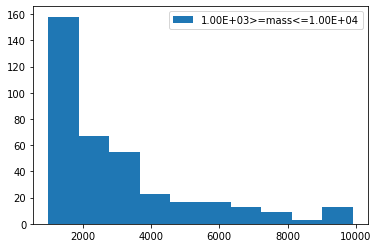

min bound: 1.00E+04, max bound 1.00E+05


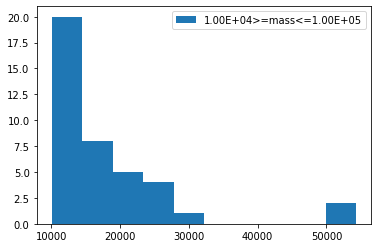

min bound: 1.00E+05, max bound 1.00E+06


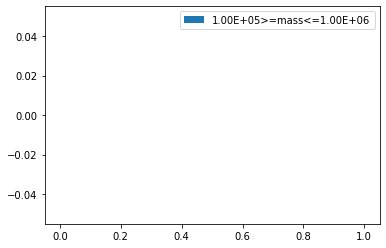

min bound: 1.00E+06, max bound 1.00E+07


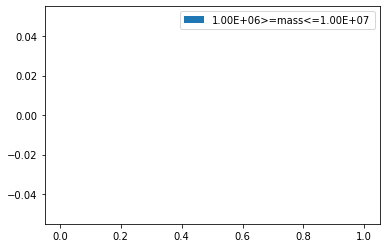

min bound: 1.00E+07, max bound 1.00E+08


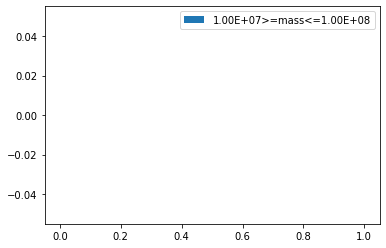

min bound: 1.00E+08, max bound 1.00E+09


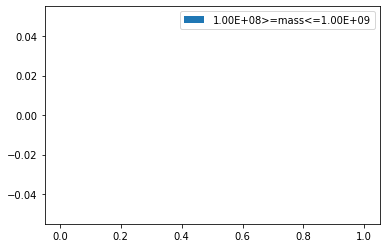

In [6]:
######################################
#create some mass ranges for plotting#
######################################

masklist = [] #initialise array to hold masks
boundslist = [] #initialise array to hold min, max bounds for that mask (for plotting)

#get the minimum and maximum halo masses in the list
min_mass = np.amin(shmasses)
max_mass = np.amax(shmasses)
print('min halo mass: {0}, max halo mass: {1} msun/h'.format(min_mass,max_mass))

#set the bounds for plotting
#massrangebounds = np.linspace(min_mass,max_mass,10)
#massrangebounds = np.logspace(0,10,10)
massrangebounds = np.array([1*10**(i) for i in np.arange(10)])

print('bounds of our mass ranges: {0}'.format(massrangebounds))

#turn these bounds into masks for the full dataset
for i in range(len(massrangebounds)-1):
    
    #get the lower and upper bound for this data mask
    min_bound = massrangebounds[i]
    max_bound = massrangebounds[i+1]
    boundslist.append([min_bound,max_bound]) #append to array
    print('min bound: {0:.2E}, max bound {1:.2E}'.format(min_bound,max_bound))
    
    #create the data mask
    mask = (shmasses>=min_bound) & (shmasses<=max_bound)
    masklist.append(mask) #append to array
    #print('created mask: {0}'.format(mask))
    #print('masses in this mask: {0}'.format(np.array(shmasses)[mask]))
    plt.hist(np.array(shmasses)[mask],label='{0:.2E}>=mass<={1:.2E}'.format(min_bound,max_bound))
    plt.legend()
    plt.show()
    
    

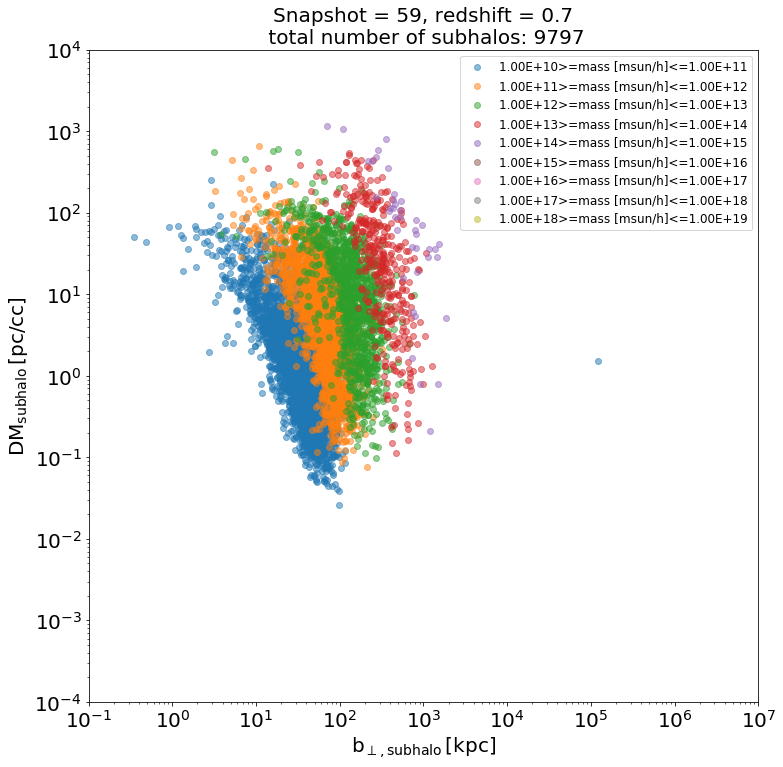

In [7]:
#initialise figure

fig = plt.figure(figsize=(12,12))
ax=fig.add_subplot(111)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-1,1e7])
ax.set_ylim([1e-4,1e4])
ax.set_xlabel(r'$\rm{b_{\perp,subhalo}\,[kpc]}$',fontsize=20)
ax.set_ylabel(r'$\rm{DM_{subhalo}\,[pc/cc]}$',fontsize=20)
ax.set_title('Snapshot = {0}, redshift = {1:.1f}\n total number of subhalos: {2}'.format(snap_number,
                                                                                         redshift,
                                                                                         len(sh_IFs)),fontsize=20)
ax.tick_params(axis='both',which='major',labelsize=20)

#loop over masks to separate out data
for i in range(len(masklist)):
    
    #get the relevant IF, DM data for this mask
    my_mask = masklist[i]
    x = sh_IFs[my_mask]
    y = sh_DMs[my_mask]
    
    #get the relevant upper and lower mass bounds
    my_bounds = boundslist[i]
    a = my_bounds[0] #lower bound
    b = my_bounds[1] #upper bound

    ax.scatter(x,y,alpha=0.5,label='{0:.2E}>=mass [msun/h]<={1:.2E}'.format(a*1e10,b*1e10))
    
ax.legend(fontsize=12)
plt.show()

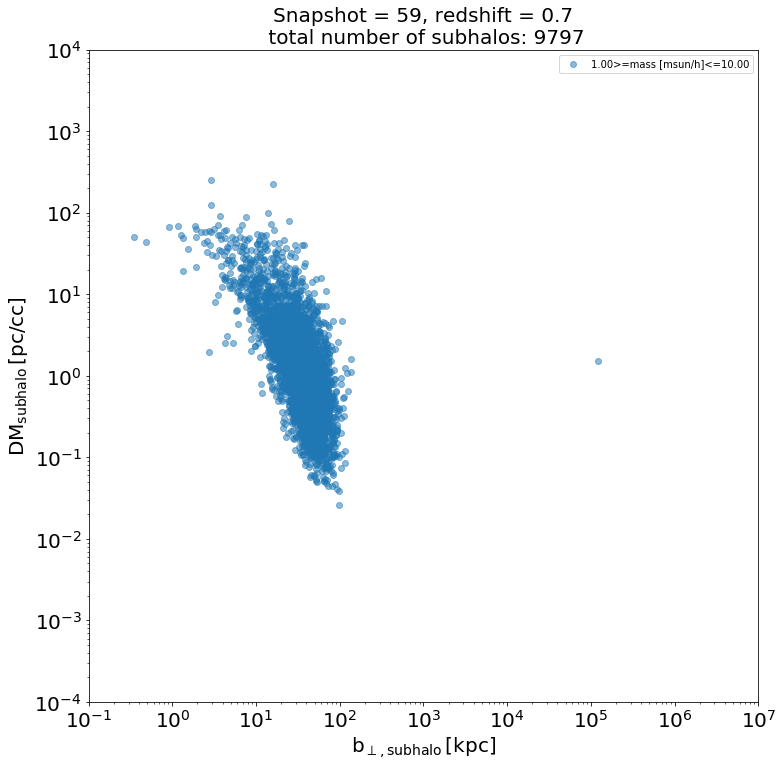

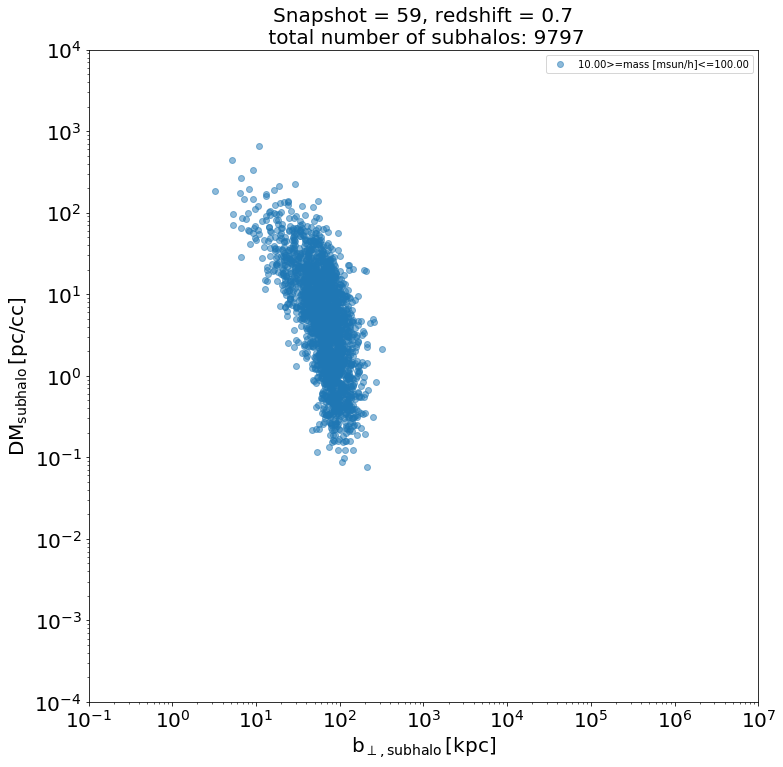

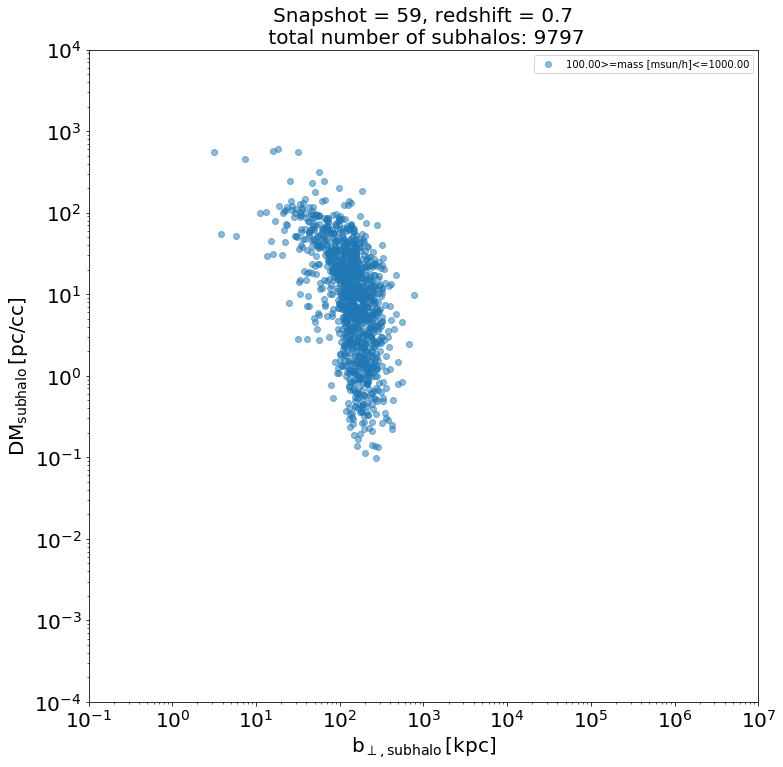

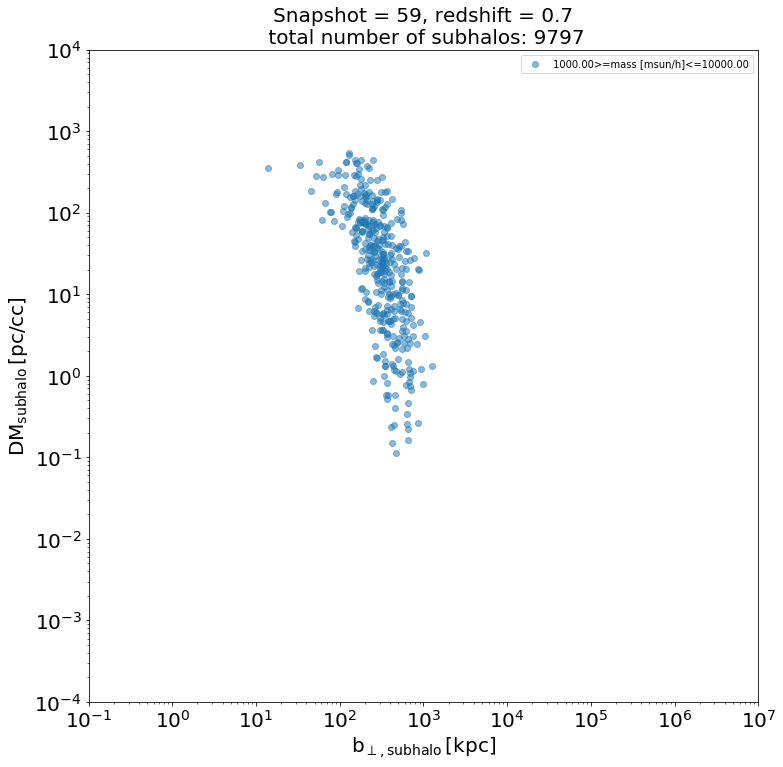

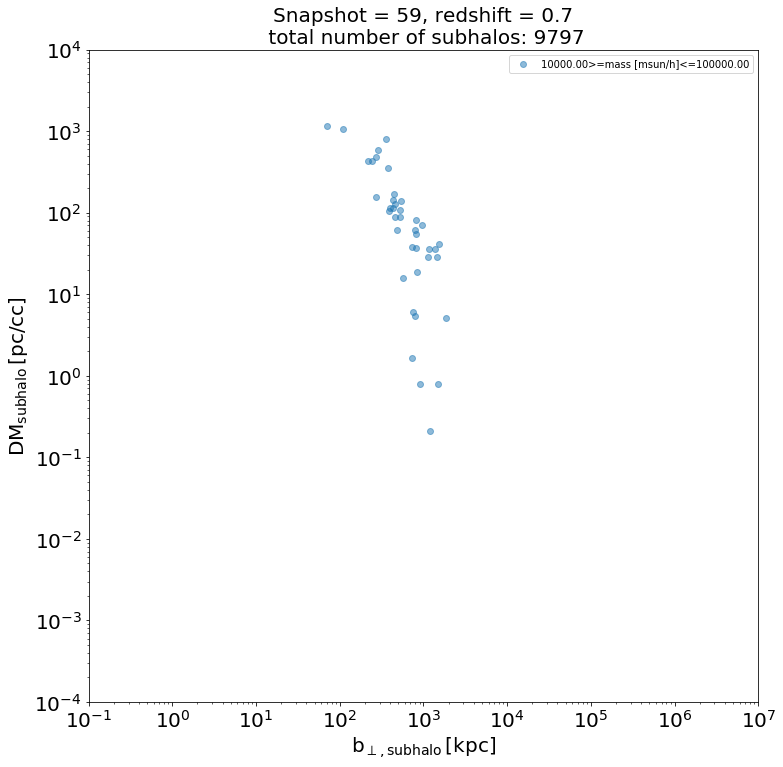

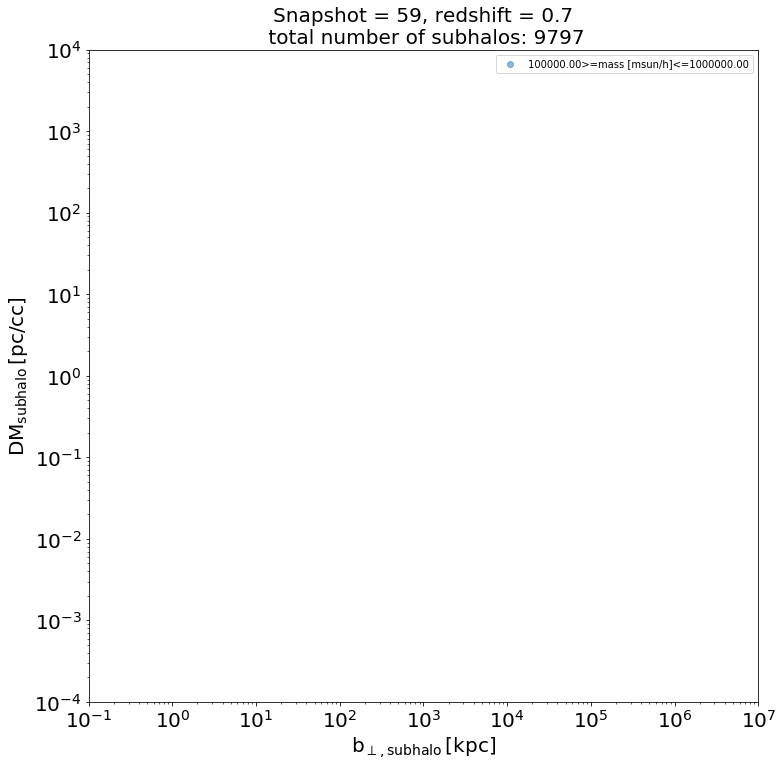

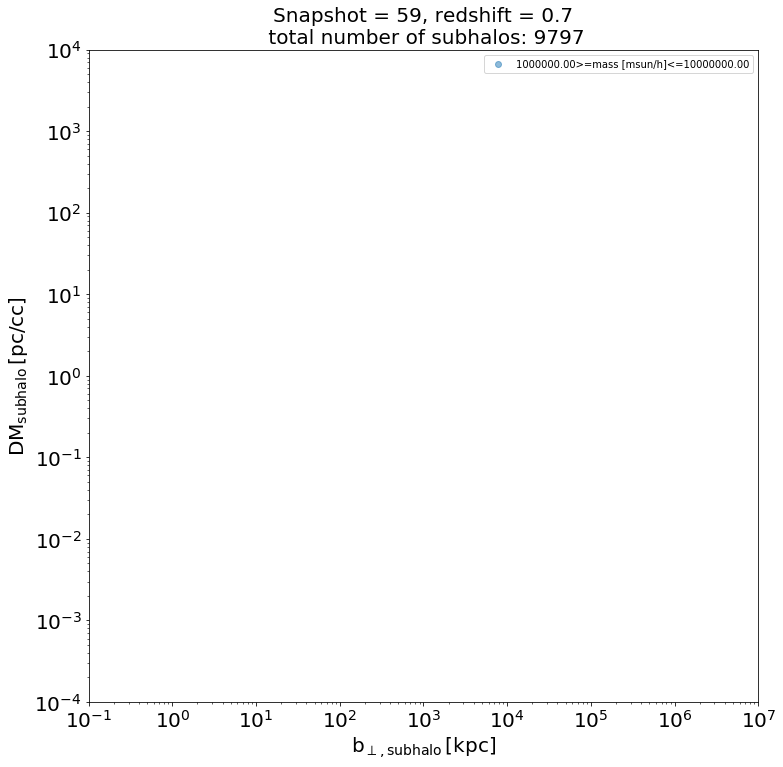

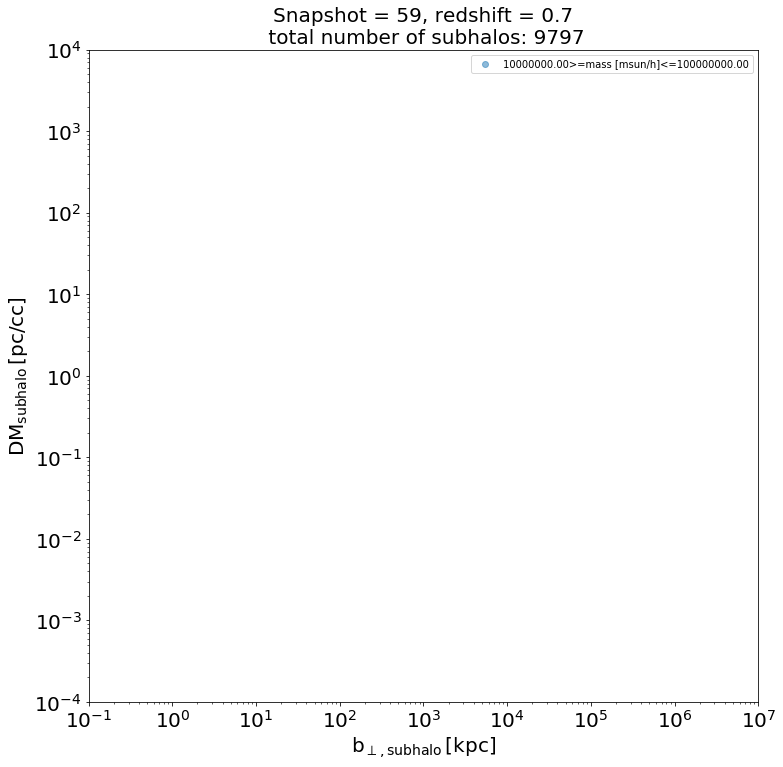

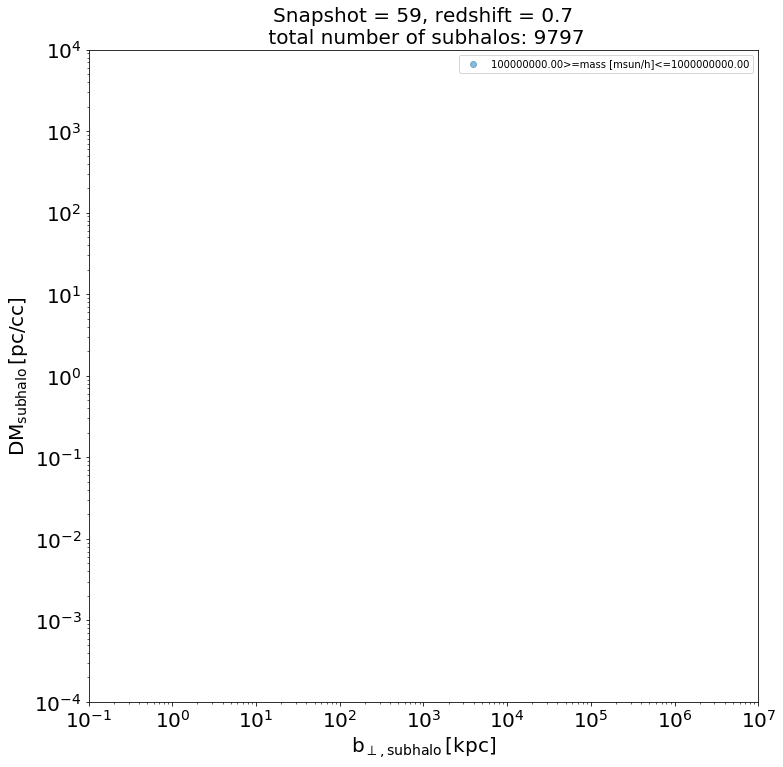

In [8]:

#loop over masks to separate out data
for i in range(len(masklist)):
    
    #initialise figure

    fig = plt.figure(figsize=(12,12))
    ax=fig.add_subplot(111)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([1e-1,1e7])
    ax.set_ylim([1e-4,1e4])
    ax.set_xlabel(r'$\rm{b_{\perp,subhalo}\,[kpc]}$',fontsize=20)
    ax.set_ylabel(r'$\rm{DM_{subhalo}\,[pc/cc]}$',fontsize=20)
    ax.set_title('Snapshot = {0}, redshift = {1:.1f}\n total number of subhalos: {2}'.format(snap_number,
                                                                                             redshift,
                                                                                             len(sh_IFs)),fontsize=20)
    ax.tick_params(axis='both',which='major',labelsize=20)


    #get the relevant IF, DM data for this mask
    my_mask = masklist[i]
    x = sh_IFs[my_mask]
    y = sh_DMs[my_mask]
    
    #get the relevant upper and lower mass bounds
    my_bounds = boundslist[i]
    a = my_bounds[0] #lower bound
    b = my_bounds[1] #upper bound

    ax.scatter(x,y,alpha=0.5,label='{0:.2f}>=mass [msun/h]<={1:.2f}'.format(a,b))
    ax.legend()
    plt.show()
    
#ax.legend(fontsize=12)

In [9]:
print(np.logspace(1,100,10))

[1.e+001 1.e+012 1.e+023 1.e+034 1.e+045 1.e+056 1.e+067 1.e+078 1.e+089
 1.e+100]


In [10]:
#save the masses so we don't have to create them again
np.save('/u/cwalker/Illustris_Zhang_Method/Impact_Factor_DM_Analysis_Output/Snap_{0}_Mass_sh.npy'.format(snap_number),shmasses,allow_pickle=True)
